### Importando as bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup
import requests

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.4f}'.format
%matplotlib inline
plotsize = (16, 8)
sns.set_style('darkgrid')

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

## Explorando o DataFrame

### Dados adquiridos no site da EIA - U.S. Energy Information Administration
[Europe Brent Spot Price FOB](https://www.eia.gov/dnav/pet/hist/rbrteD.htm)

In [2]:
url = ('https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls')
dados = pd.read_excel(url, sheet_name="Data 1", skiprows=2)

In [3]:
dados.to_csv('data/RBRTEd.csv',index=False)

In [4]:
dados.head()

,Date,Europe Brent Spot Price FOB (Dollars per Barrel)
0,1987-05-20,18.6300
1,1987-05-21,18.4500
2,1987-05-22,18.5500
3,1987-05-25,18.6000
4,1987-05-26,18.6300


In [5]:
dados.shape

(9384, 2)

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9384 entries, 0 to 9383
Data columns (total 2 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   Date                                              9384 non-null   datetime64[ns]
 1   Europe Brent Spot Price FOB (Dollars per Barrel)  9384 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 146.8 KB


In [7]:
dados.isna().sum() #não há dados nulos na base

Date                                                0
Europe Brent Spot Price FOB (Dollars per Barrel)    0
dtype: int64

In [8]:
dados = dados.rename(columns={'Date': 'date',
                        'Europe Brent Spot Price FOB (Dollars per Barrel)': 'dollars_per_barrel'})
dados.head()

,date,dollars_per_barrel
0,1987-05-20,18.6300
1,1987-05-21,18.4500
2,1987-05-22,18.5500
3,1987-05-25,18.6000
4,1987-05-26,18.6300


### Ajustando o Datetime

In [9]:
dados.set_index('date', inplace=True)

In [10]:
dados.index.min()

Timestamp('1987-05-20 00:00:00')

In [11]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9384 entries, 1987-05-20 to 2024-05-13
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dollars_per_barrel  9384 non-null   float64
dtypes: float64(1)
memory usage: 146.6 KB


In [12]:
dados.index

DatetimeIndex(['1987-05-20', '1987-05-21', '1987-05-22', '1987-05-25',
               '1987-05-26', '1987-05-27', '1987-05-28', '1987-05-29',
               '1987-06-01', '1987-06-02',
               ...
               '2024-04-29', '2024-04-30', '2024-05-01', '2024-05-02',
               '2024-05-03', '2024-05-07', '2024-05-08', '2024-05-09',
               '2024-05-10', '2024-05-13'],
              dtype='datetime64[ns]', name='date', length=9384, freq=None)

**O índice não tem uma frequência definida** - freq=None

Isso acontece porque o dataset só tem registros de segunda a sexta, o ideal seria ter todos os dias dessa série no dataset para que a frequência seja de 7

In [13]:
data_range = dados.index.max() - dados.index.min()

print(f'Quantidade de dias no dataset: {len(dados.index.unique())}')
print(f'Total de dias da primeira entrada até agora: {data_range.days}')
print(f'O barril só é comercializado de segunda a sexta, portanto\
 temos {data_range.days - len(dados.index.unique())} dias sem registros durante toda a série.')

Quantidade de dias no dataset: 9384
Total de dias da primeira entrada até agora: 13508
O barril só é comercializado de segunda a sexta, portanto temos 4124 dias sem registros durante toda a série.


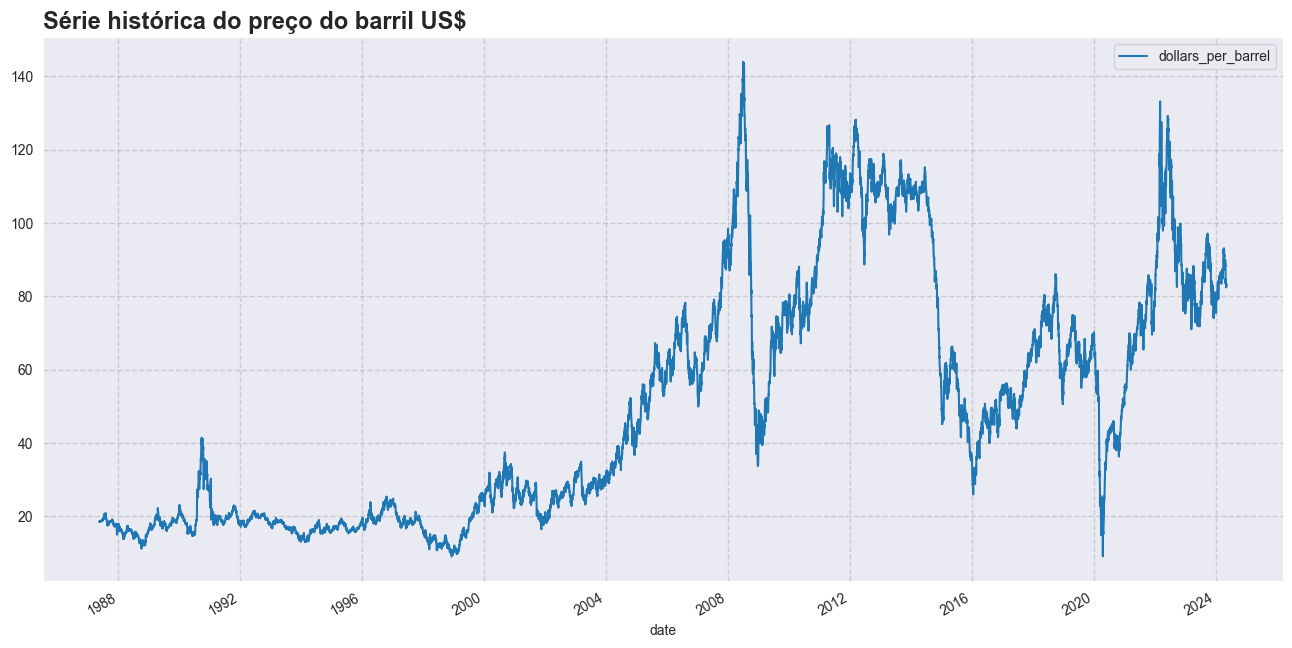

In [14]:
dados.plot(figsize=(16,8))
plt.grid(color = 'gray', linestyle= '--', linewidth = 1, alpha = 0.3)
plt.title('Série histórica do preço do barril US$', loc='left', fontsize=17, weight='bold')
plt.show()

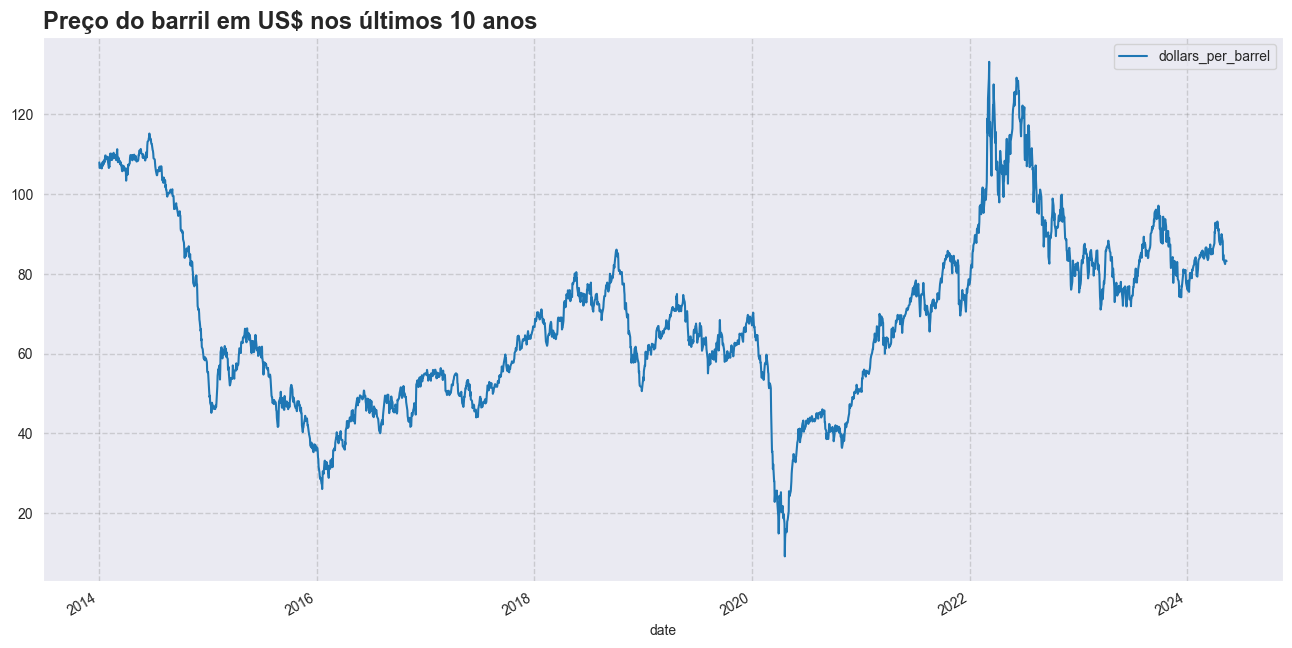

In [15]:
ultimos_10 = dados[dados.index.year.isin([2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024])]

ultimos_10.plot(figsize=(16,8))
plt.title('Preço do barril em US$ nos últimos 10 anos', loc='left', fontsize=17, weight='bold')
plt.grid(color = 'gray', linestyle= '--', linewidth = 1, alpha = 0.3)
plt.show()

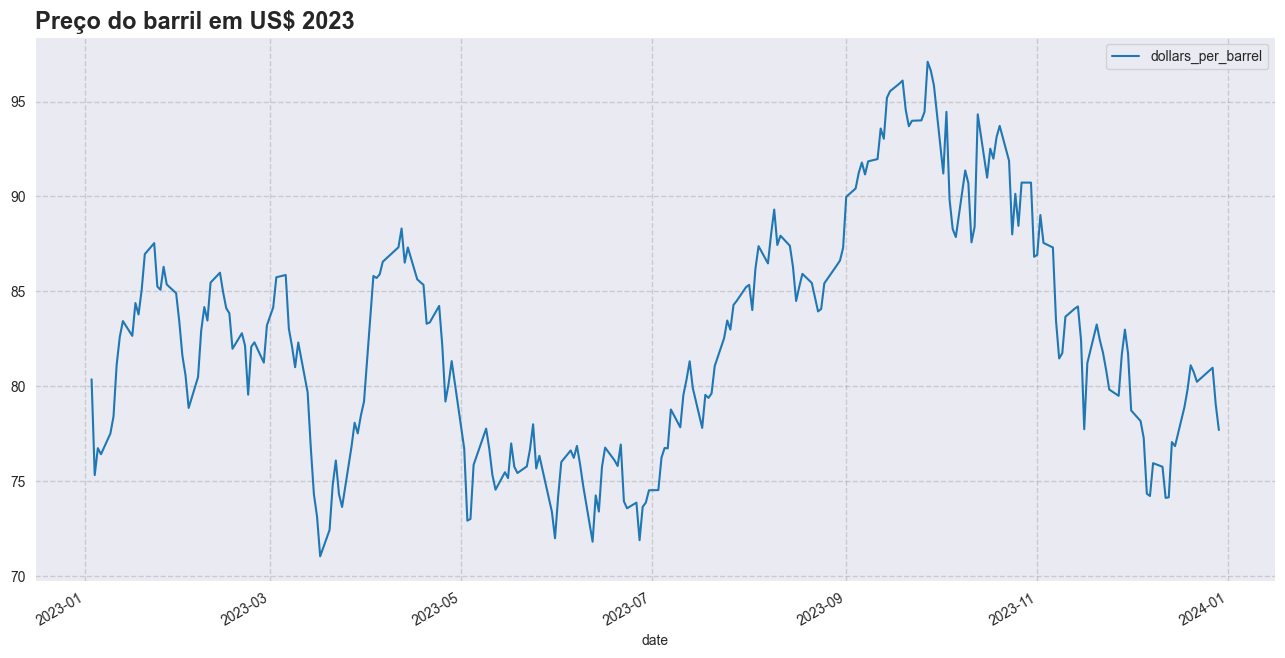

In [16]:
dados_23 = dados[dados.index.year.isin([2023])]

dados_23.plot(figsize=(16,8))
plt.title('Preço do barril em US$ 2023', loc='left', fontsize=17, weight='bold')
plt.grid(color = 'gray', linestyle= '--', linewidth = 1, alpha = 0.3)
plt.show()

## Diff

In [17]:
# criando uma cópia do df
df = dados.copy()

In [18]:
df['aumento'] = df['dollars_per_barrel'].diff()
df.head(10)

,dollars_per_barrel,aumento
date,,
1987-05-20,18.6300,NaN
1987-05-21,18.4500,-0.1800
1987-05-22,18.5500,0.1000
1987-05-25,18.6000,0.0500
1987-05-26,18.6300,0.0300
1987-05-27,18.6000,-0.0300
1987-05-28,18.6000,0.0000
1987-05-29,18.5800,-0.0200
1987-06-01,18.6500,0.0700


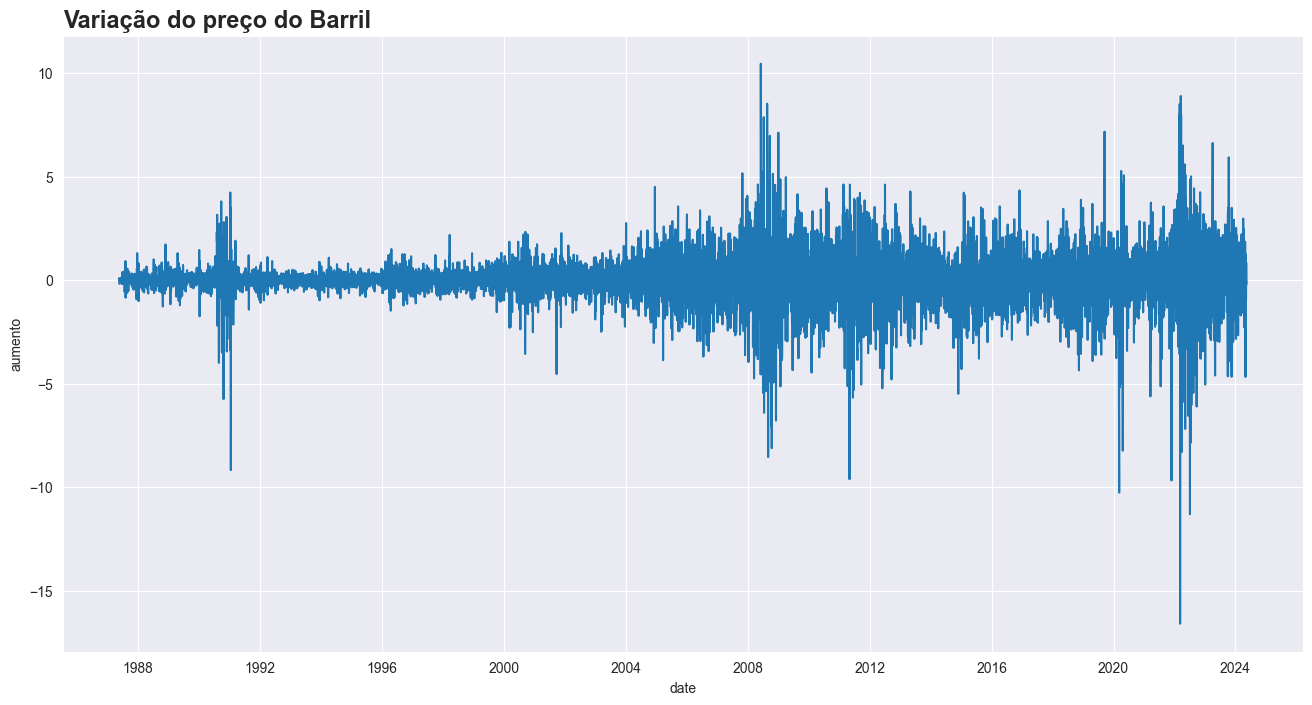

In [19]:
ax = sns.lineplot(x='date', y='aumento', data=df)
ax.figure.set_size_inches(16,8)
plt.title('Variação do preço do Barril', loc='left', fontsize=17, weight='bold')
ax=ax

## Média Movel e Janelas

In [20]:
tam_janela = 5 #nossa série tem períodos de 5 dias por semana

janela = dados.rolling(tam_janela).mean()
janela.head(10)

,dollars_per_barrel
date,
1987-05-20,NaN
1987-05-21,NaN
1987-05-22,NaN
1987-05-25,NaN
1987-05-26,18.5720
1987-05-27,18.5660
1987-05-28,18.5960
1987-05-29,18.6020
1987-06-01,18.6120


In [21]:
janela = dados.rolling(tam_janela)
print(janela.mean().dropna().head(5))

            dollars_per_barrel
date                          
1987-05-26             18.5720
1987-05-27             18.5660
1987-05-28             18.5960
1987-05-29             18.6020
1987-06-01             18.6120


Text(0.0, 1.0, 'Média Móvel')

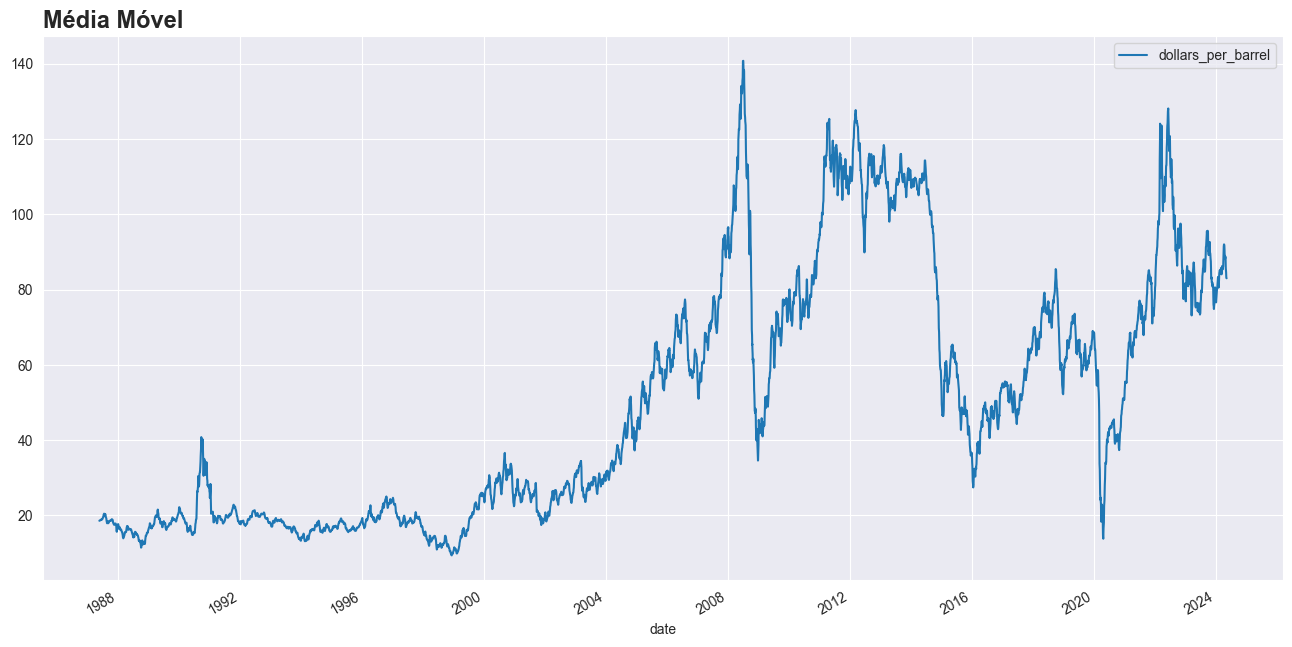

In [22]:
janela.mean().dropna().plot(figsize=(16,8))
plt.title('Média Móvel', loc='left', fontsize=17, weight='bold')

Text(0.0, 1.0, 'Desvio Padrão')

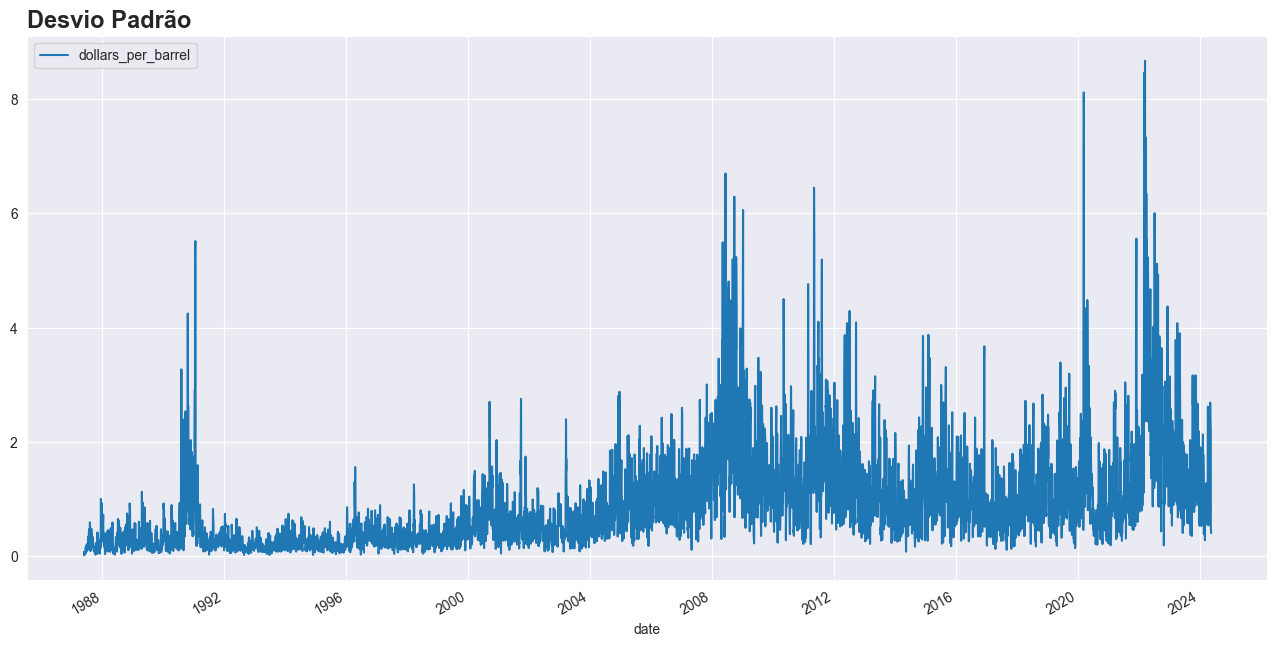

In [23]:
janela.std().dropna().plot(figsize=(16,8))
plt.title('Desvio Padrão', loc='left', fontsize=17, weight='bold')

## Upsampling

In [24]:
preco_semanal = dados.resample('W').sum()
preco_semanal.head()

,dollars_per_barrel
date,
1987-05-24,55.6300
1987-05-31,93.0100
1987-06-07,93.5100
1987-06-14,93.7700
1987-06-21,76.0300


In [25]:
preco_mensal = dados.resample('M').sum()
preco_mensal.head()

,dollars_per_barrel
date,
1987-05-31,148.6400
1987-06-30,396.0700
1987-07-31,456.7000
1987-08-31,398.5700
1987-09-30,402.8900


In [26]:
preco_trimestral = dados.resample('Q').sum()
preco_trimestral.head()

,dollars_per_barrel
date,
1987-06-30,544.7100
1987-09-30,"1,258.1600"
1987-12-31,"1,161.2600"
1988-03-31,970.6300
1988-06-30,"1,016.1800"


In [27]:
preco_anual = dados.resample('Y').sum()
preco_anual.head()

,dollars_per_barrel
date,
1987-12-31,"2,964.1300"
1988-12-31,"3,800.8800"
1989-12-31,"4,629.9700"
1990-12-31,"6,082.9300"
1991-12-31,"5,150.5700"


<Axes: title={'center': 'Cumulativo do preço semanal'}, xlabel='date'>

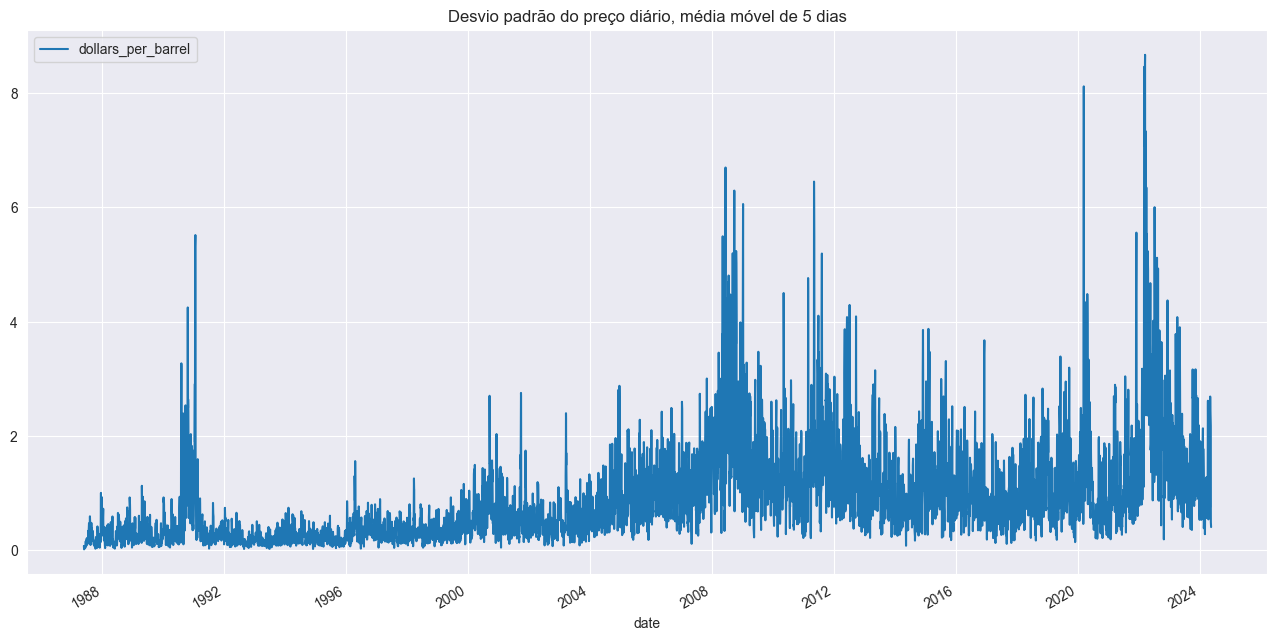

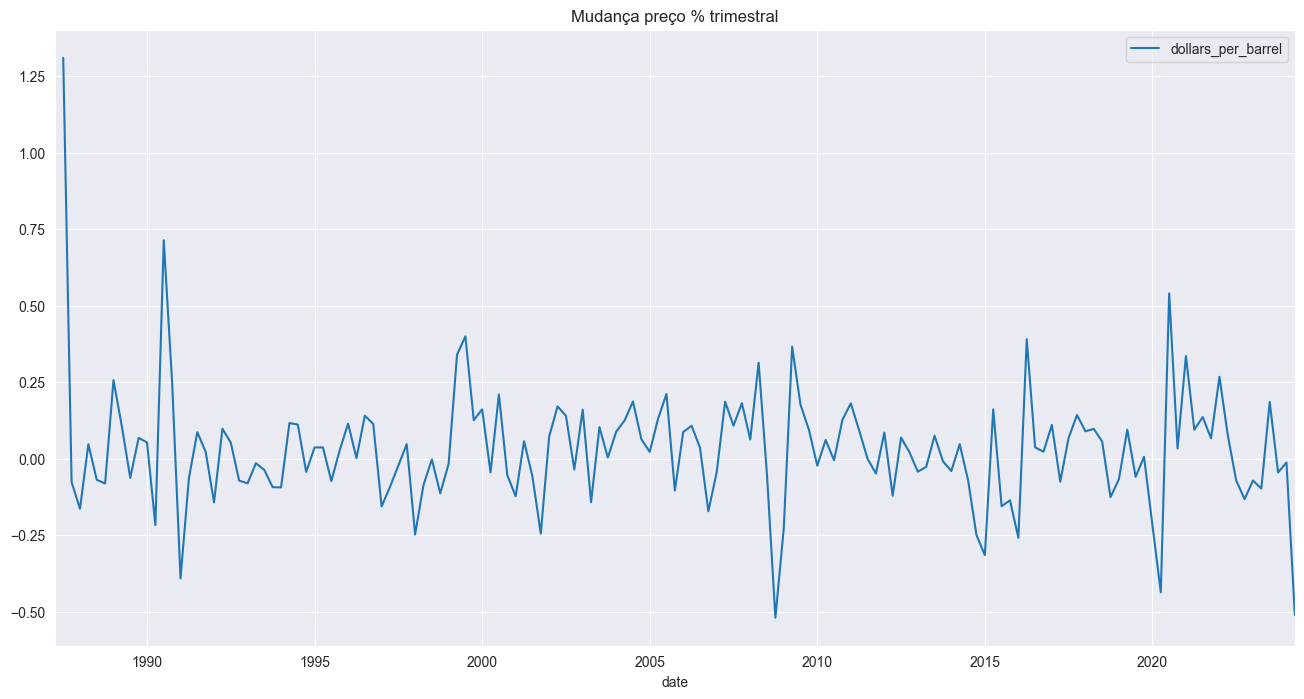

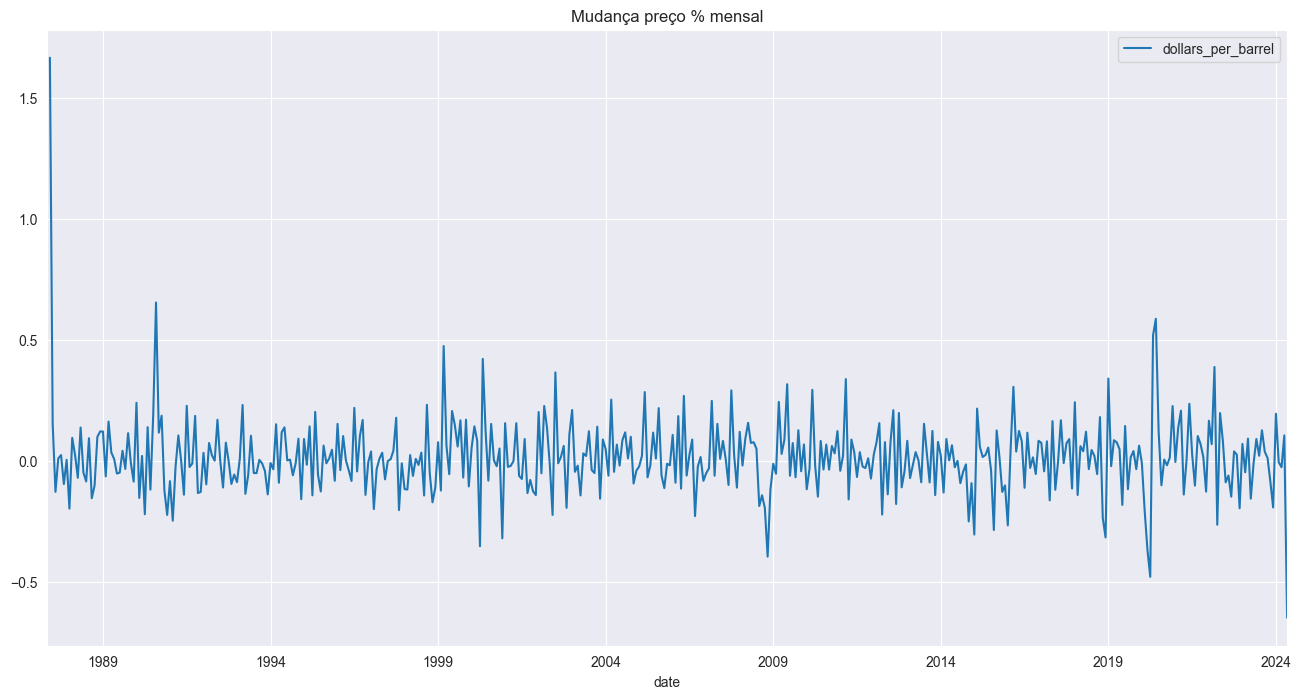

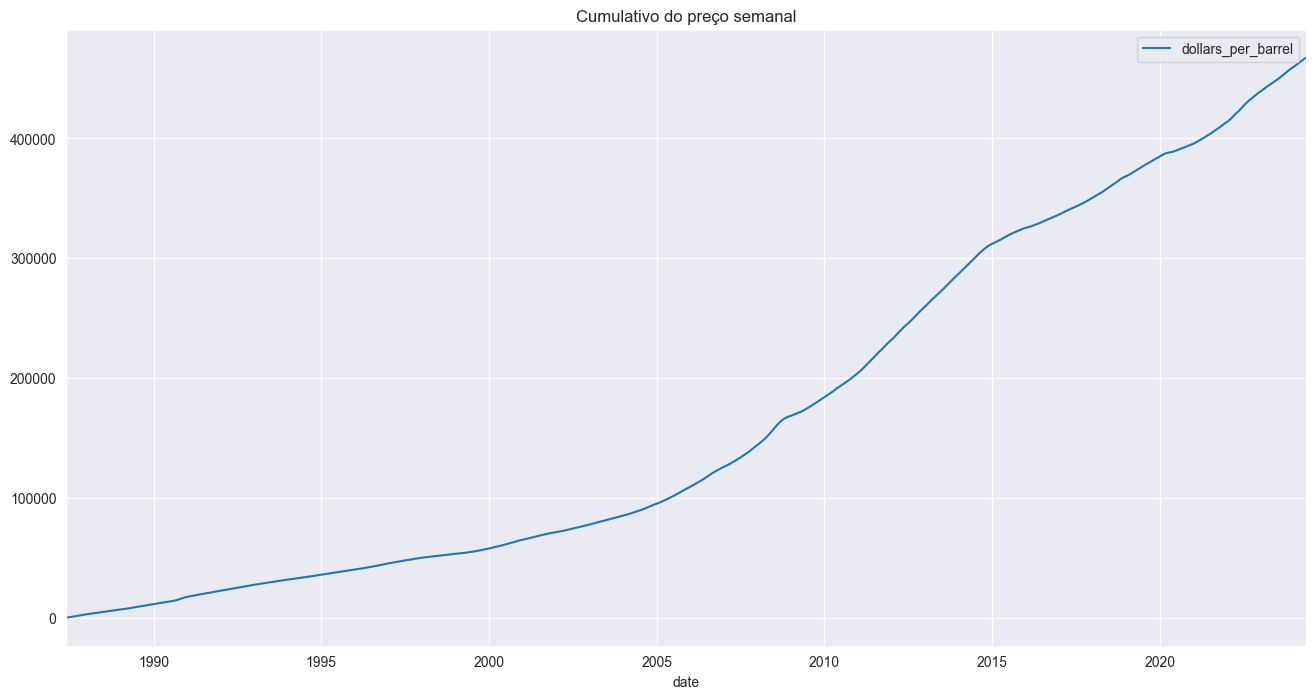

In [28]:
janela.std().plot(figsize=plotsize, title='Desvio padrão do preço diário, média móvel de 5 dias')
preco_trimestral.pct_change().plot(figsize=plotsize, title='Mudança preço % trimestral')
preco_mensal.pct_change().plot(figsize=plotsize, title='Mudança preço % mensal')
preco_semanal.cumsum().plot(figsize=plotsize, title='Cumulativo do preço semanal')

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

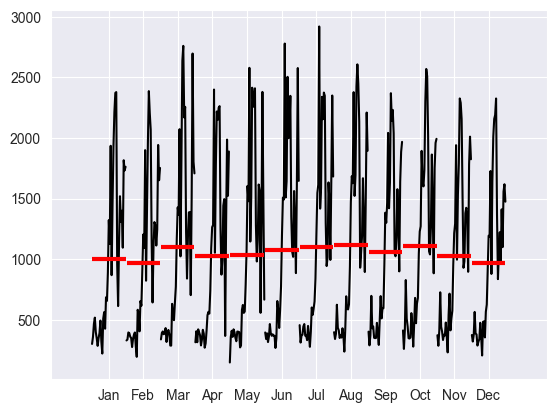

In [30]:
plot_mensal = month_plot(preco_mensal)


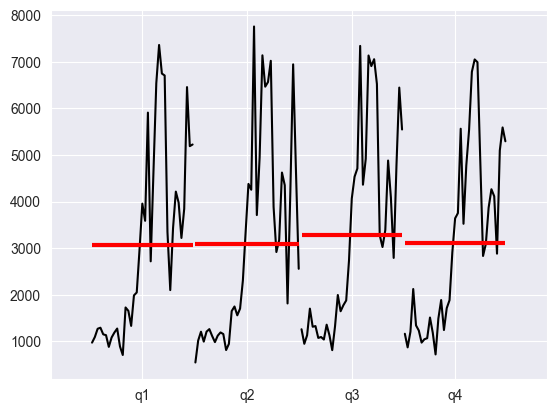

In [31]:
plot_trimestral = quarter_plot(preco_trimestral)

## Decompondo a série

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [33]:
ss_decomposition = seasonal_decompose(dados, model='additive', period=261)

tendencia_estimada = ss_decomposition.trend
sazonalidade_estimada = ss_decomposition.seasonal
residuo_estimado = ss_decomposition.resid

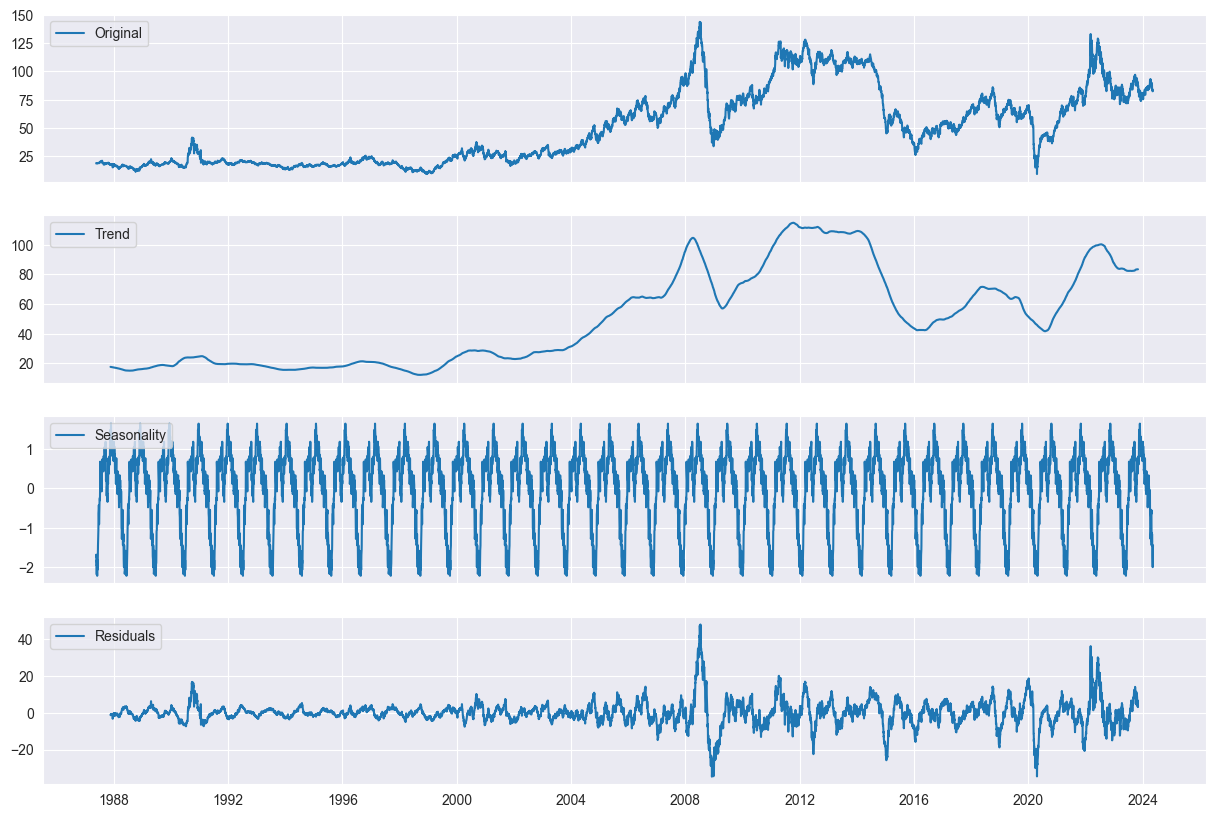

In [34]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(dados, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(tendencia_estimada, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(sazonalidade_estimada, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(residuo_estimado, label='Residuals')
axes[3].legend(loc='upper left');

In [35]:
ss_decomposition = seasonal_decompose(dados, model='multiplicative', period=261)

tendencia_estimada = ss_decomposition.trend
sazonalidade_estimada = ss_decomposition.seasonal
residuo_estimado = ss_decomposition.resid

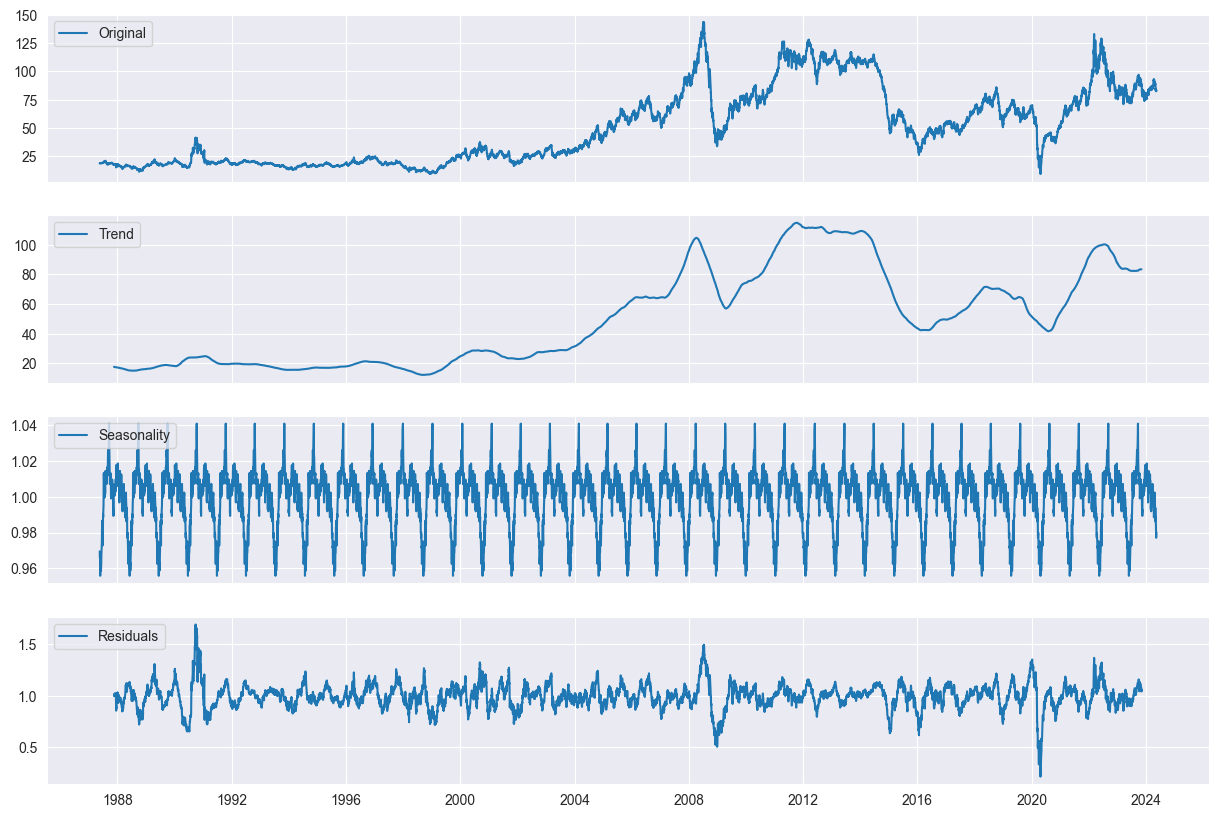

In [36]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(dados, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(tendencia_estimada, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(sazonalidade_estimada, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(residuo_estimado, label='Residuals')
axes[3].legend(loc='upper left');

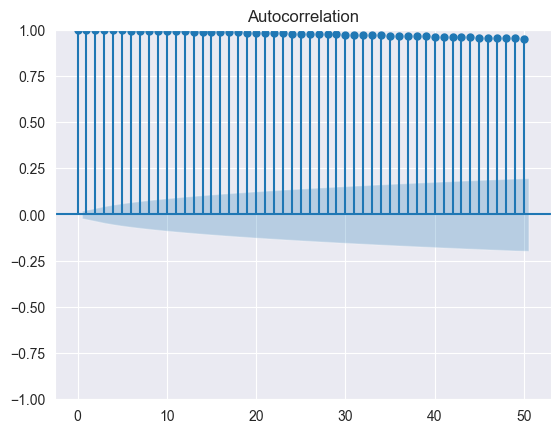

In [37]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(dados, lags=50)
plt.show()

## Estacionaridade e autocorrelação

Para que uma Time Series seja estacionaria os dados devem exibir quatro caracteristicas ao longo do tempo:
- média constante
- variancia constante
- estrutura de autocorrelação constante
- sem componentes periódicos (sazonalidade)

### Augmented Dickey-Fuller Test

In [38]:
from statsmodels.tsa.stattools import adfuller

In [39]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(dados['dollars_per_barrel'])

#### Como interpretar os resultados do teste ADF?
Os resultados do teste ADF fornecerão uma estatística de teste e um valor p. A estatística do teste é comparada com os valores críticos em diferentes níveis de significância, geralmente 1%, 5% e 10%. Se a estatística de teste for mais negativa do que o valor crítico, você poderá rejeitar a hipótese nula e concluir que a série temporal está estacionária. Se a estatística de teste for menos negativa que o valor crítico, você não poderá rejeitar a hipótese nula e concluir que a série temporal tem uma raiz unitária. O valor de p é a probabilidade de se obter uma estatística de teste tão extrema ou mais extrema do que a observada sob a hipótese nula. Se o valor de p for menor que o nível de significância, você poderá rejeitar a hipótese nula e concluir que a série temporal está estacionária. Se o valor de p for maior que o nível de significância, você não poderá rejeitar a hipótese nula e concluir que a série temporal tem uma raiz unitária.

In [40]:
print('>> ADF TEST RESULTS')
print(f'estatística de teste: {adf}')
print(f'p-value: {pvalue}')
print('critical values:')
resultado_adf = adfuller(dados['dollars_per_barrel'])
for key, value in resultado_adf[4].items():
    print(f'   {key}: {value}')

>> ADF TEST RESULTS
estatística de teste: -2.144432290268367
p-value: 0.2270273468841822
critical values:
   1%: -3.431049283240778
   5%: -2.86184903924505
   10%: -2.5669344965040986


- A série não é estacionária

## Transformando a série em estacionária

#### teste 1 - subtrair dados logaritmicos pela ma

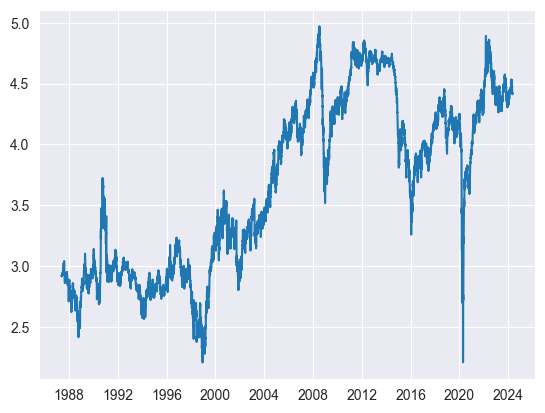

In [41]:
dados_log = np.log(dados)
plt.plot(dados_log)

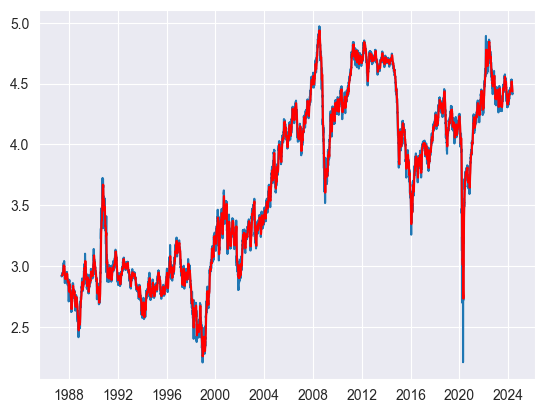

In [42]:
# calculando a média móvel
movingavg = dados_log.rolling(window=10).mean()
movingSTD = dados_log.rolling(window=10).std()
plt.plot(dados_log)
plt.plot(movingavg, color='red')

In [43]:
dados_log_menos_ma = dados_log - movingavg
dados_log_menos_ma.dropna(inplace = True)
dados_log_menos_ma.head(15)

,dollars_per_barrel
date,
1987-06-02,0.0045
1987-06-03,0.0076
1987-06-04,0.0074
1987-06-05,-0.0001
1987-06-08,0.0044
1987-06-09,0.0052
1987-06-10,0.0043
1987-06-11,-0.0015
1987-06-12,0.0028


In [44]:
def test_stationarity(timeseries):

    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(timeseries['dollars_per_barrel'])

    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #plot
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #adf:
    print('>> ADF TEST RESULTS')
    print(f'estatística de teste: {adf}')
    print(f'p-value: {pvalue}')
    print(f'# lags usados: {usedlag}')
    print('critical values:')
    resultado_adf = adfuller(dados['dollars_per_barrel'])
    for key, value in resultado_adf[4].items():
        print(f'   {key}: {value}')

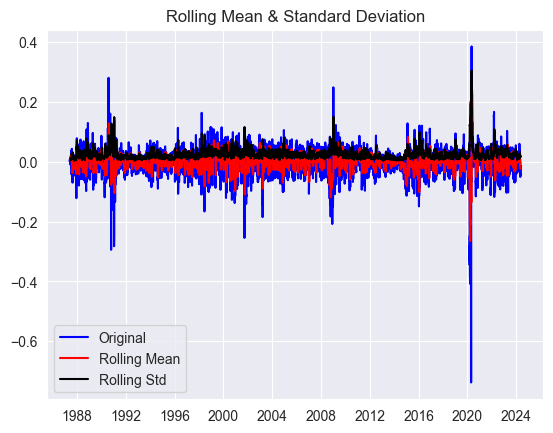

>> ADF TEST RESULTS
estatística de teste: -16.085184102157797
p-value: 5.325840201477369e-29
# lags usados: 29
critical values:
   1%: -3.431049283240778
   5%: -2.86184903924505
   10%: -2.5669344965040986


In [45]:
test_stationarity(dados_log_menos_ma)

#### teste 2: decaimento exponencial

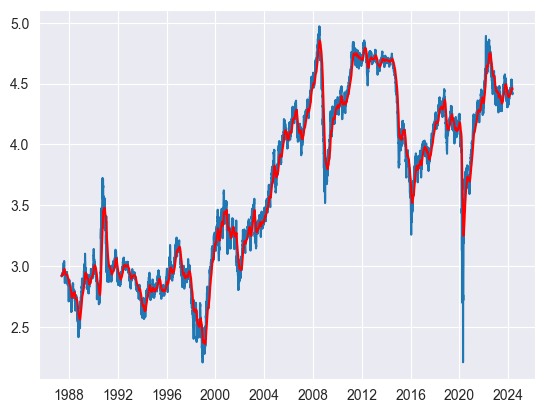

In [46]:
dados_media_exp = dados_log.ewm(halflife=20, min_periods=0, adjust=True).mean()
plt.plot(dados_log)
plt.plot(dados_media_exp, color='red')

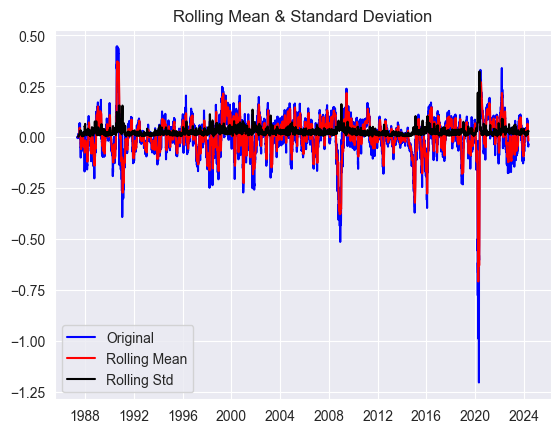

>> ADF TEST RESULTS
estatística de teste: -11.588418161169523
p-value: 2.830363232180071e-21
# lags usados: 29
critical values:
   1%: -3.431049283240778
   5%: -2.86184903924505
   10%: -2.5669344965040986


In [47]:
dados_log_menos_ma_exp = dados_log - dados_media_exp
test_stationarity(dados_log_menos_ma_exp)

#### teste 3: diferenciação

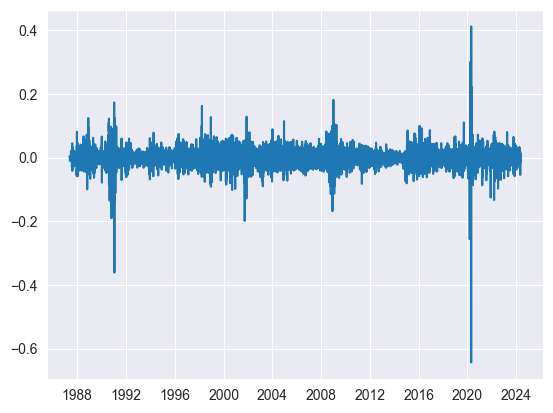

In [48]:
dados_log_diff = dados_log - dados_log.shift()
plt.plot(dados_log_diff)

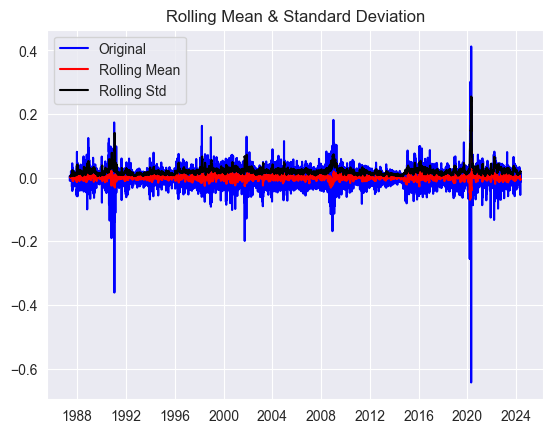

>> ADF TEST RESULTS
estatística de teste: -16.78507400486985
p-value: 1.2551374029279736e-29
# lags usados: 28
critical values:
   1%: -3.431049283240778
   5%: -2.86184903924505
   10%: -2.5669344965040986


In [49]:
dados_log_diff.dropna(inplace=True)
test_stationarity(dados_log_diff)

## Teste de Correlação Parcial

In [50]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

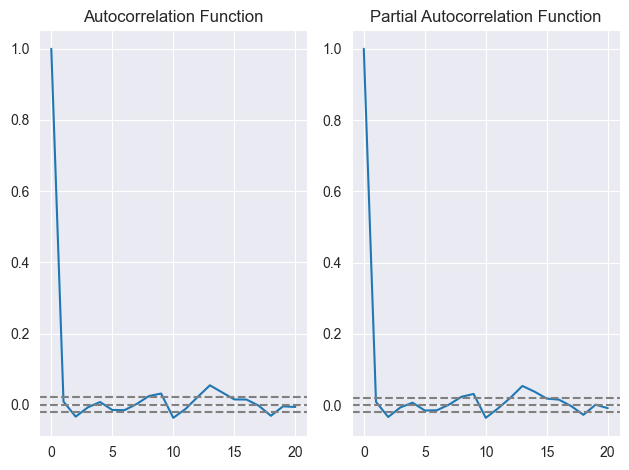

In [51]:
lag_acf = acf(dados_log_diff, nlags=20)
lag_pacf = pacf(dados_log_diff, nlags=20, method='ols')

#ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dados_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dados_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dados_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dados_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

## ARIMA

In [52]:
model = ARIMA(dados_log_diff, order=(2,1,2))
results_ar = model.fit()

/Users/giuliana/Desktop/GitHub/tech_challenge-oil_forecasting/oilenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/giuliana/Desktop/GitHub/tech_challenge-oil_forecasting/oilenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/giuliana/Desktop/GitHub/tech_challenge-oil_forecasting/oilenv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/giuliana/Desktop/GitHub/tech_challenge-oil_forecasting/oilenv/lib/pyt

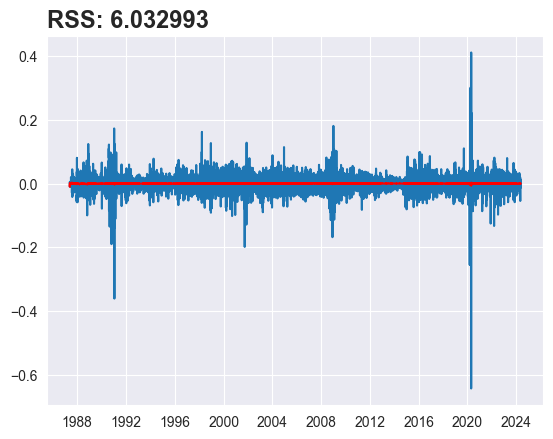

In [53]:
plt.plot(dados_log_diff)
plt.plot(results_ar.fittedvalues, color='red')
plt.title('RSS: %4f'%sum((results_ar.fittedvalues - dados_log_diff['dollars_per_barrel'])**2),
          loc='left', fontsize=17, weight='bold')
plt.show()

#### Validando com MAPE

In [54]:
from sklearn.metrics import mean_absolute_error

In [55]:
predictions = results_ar.fittedvalues
predictions.index = dados_log_diff.index

predicted_values = dados_log['dollars_per_barrel'].iloc[0] + np.cumsum(predictions)

#mape
mape = mean_absolute_error(dados_log_diff['dollars_per_barrel'], predicted_values) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 326.38%


## Prophet

In [56]:
from prophet import Prophet

In [57]:
dados_prophet = dados.loc['2013-05-01':]

In [58]:
dados_prophet.head()

,dollars_per_barrel
date,
2013-05-01,98.3400
2013-05-02,100.3200
2013-05-03,104.6000
2013-05-06,105.0000
2013-05-07,105.1800


In [59]:
dados_prophet = dados_prophet.reset_index('date')
dados_prophet[['ds', 'y']] = dados_prophet[['date', 'dollars_per_barrel']]
dados_prophet.drop(columns=['date', 'dollars_per_barrel'], inplace=True)
dados_prophet.head()

,ds,y
0,2013-05-01,98.3400
1,2013-05-02,100.3200
2,2013-05-03,104.6000
3,2013-05-06,105.0000
4,2013-05-07,105.1800


In [60]:
train_data = dados_prophet.sample(frac=0.8, random_state=0)
test_data = dados_prophet.drop(train_data.index)

print(f'Tamanho dos dados de treino: {train_data.shape}')
print(f'Tamanho dos dados de teste: {test_data.shape}')

Tamanho dos dados de treino: (2242, 2)
Tamanho dos dados de teste: (560, 2)


In [61]:
model = Prophet(daily_seasonality=True)
model.fit(train_data)
future_data = model.make_future_dataframe(periods=20, freq='M')
previsao = model.predict(future_data)
previsao.head()


15:53:10 - cmdstanpy - INFO - Chain [1] start processing
15:53:11 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-05-02,100.2536,94.6282,114.1969,100.2536,100.2536,4.3976,4.3976,4.3976,4.1768,...,0.3807,0.3807,0.3807,-0.1599,-0.1599,-0.1599,0.0000,0.0000,0.0000,104.6512
1,2013-05-03,100.2781,95.6751,114.6237,100.2781,100.2781,4.4000,4.4000,4.4000,4.1768,...,0.3165,0.3165,0.3165,-0.0933,-0.0933,-0.0933,0.0000,0.0000,0.0000,104.6781
2,2013-05-07,100.3760,95.4625,114.9136,100.3760,100.3760,4.7371,4.7371,4.7371,4.1768,...,0.1973,0.1973,0.1973,0.3630,0.3630,0.3630,0.0000,0.0000,0.0000,105.1131
3,2013-05-08,100.4005,95.3929,114.5342,100.4005,100.4005,4.4576,4.4576,4.4576,4.1768,...,-0.2385,-0.2385,-0.2385,0.5193,0.5193,0.5193,0.0000,0.0000,0.0000,104.8581
4,2013-05-09,100.4250,96.1516,115.6530,100.4250,100.4250,5.2464,5.2464,5.2464,4.1768,...,0.3807,0.3807,0.3807,0.6889,0.6889,0.6889,0.0000,0.0000,0.0000,105.6714


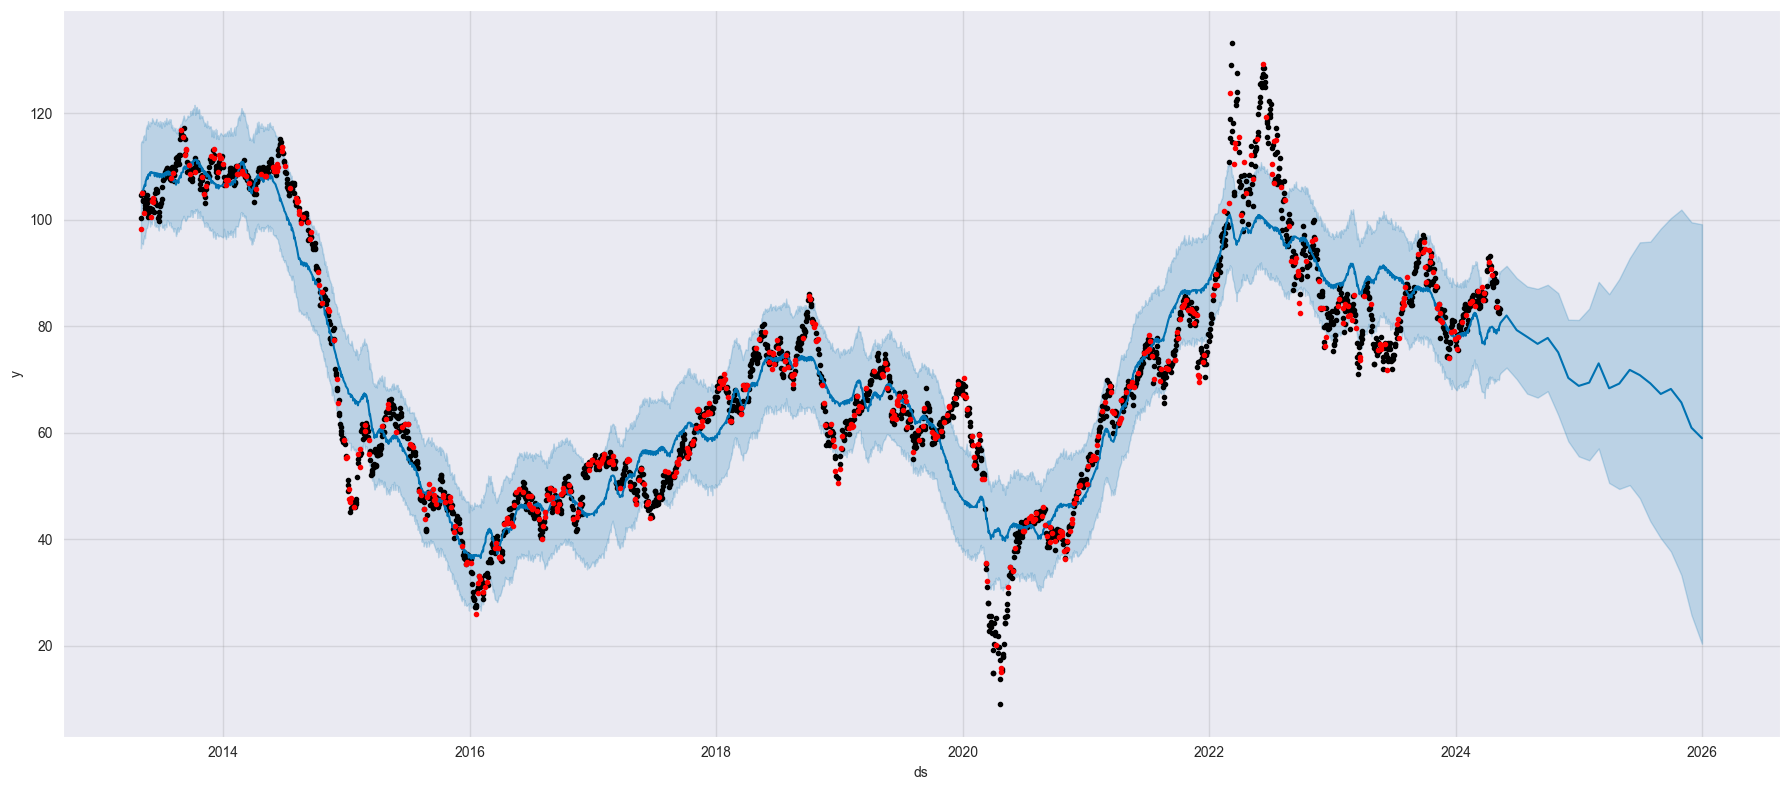

In [62]:
model.plot(previsao, figsize=(18,8));
plt.plot(test_data['ds'], test_data['y'], '.r')

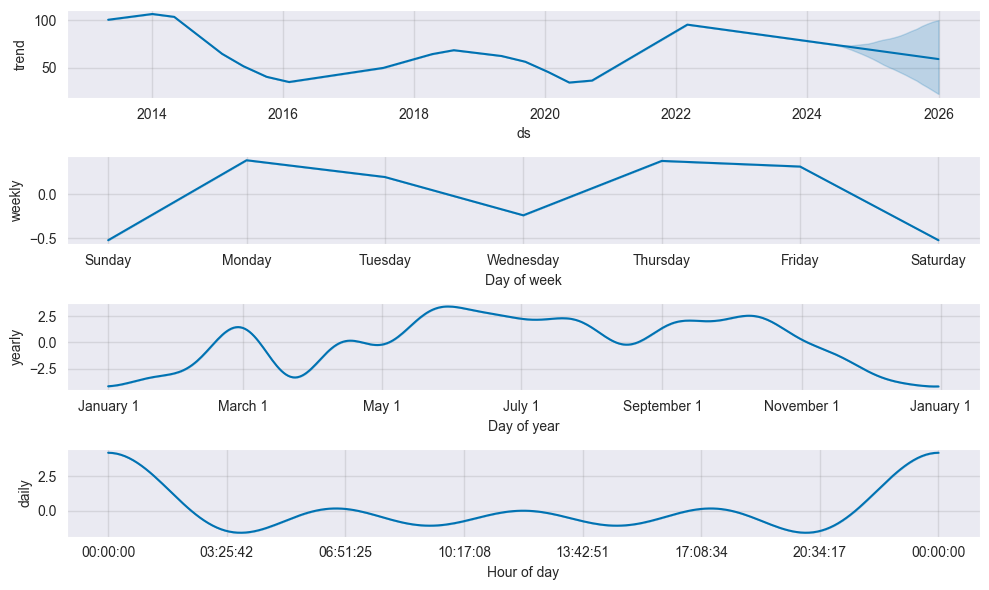

In [63]:
model.plot_components(previsao, figsize=(10,6));

In [64]:
# extraindo colunas mais relevantes
colunas_previsao = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[colunas_previsao]
valores_reais = train_data[valores_reais_cols]

#concatenando os resultados para comparação
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) *100

mape = np.mean(resultados['erro_percentual_absoluto'])
print(f'mape: {mape:.2f}%')

mape: 9.27%


#### Validação Cruzada

In [65]:
from prophet.diagnostics import cross_validation

dados_cv = cross_validation(model, initial='2164 days', period='261 days', horizon='261 days')

  0%|          | 0/7 [00:00<?, ?it/s]15:53:12 - cmdstanpy - INFO - Chain [1] start processing
15:53:12 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:01,  3.19it/s]15:53:12 - cmdstanpy - INFO - Chain [1] start processing
15:53:13 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:00<00:01,  2.93it/s]15:53:13 - cmdstanpy - INFO - Chain [1] start processing
15:53:13 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:00<00:01,  3.39it/s]15:53:13 - cmdstanpy - INFO - Chain [1] start processing
15:53:13 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:01<00:00,  3.63it/s]15:53:13 - cmdstanpy - INFO - Chain [1] start processing
15:53:14 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:01<00:00,  3.12it/s]15:53:14 - cmdstanpy - INFO - Chain [1] start processing
15:53:14 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:02<00:00,  2.60it/s]15:53:14 - cmds

In [66]:
dados_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-05-14,72.4212,67.8468,77.3896,72.5300,2019-05-13
1,2019-05-16,72.5300,68.0555,77.6037,74.7000,2019-05-13
2,2019-05-17,72.6600,68.0944,77.3322,73.9400,2019-05-13
3,2019-05-20,72.7783,67.9452,77.6991,73.2100,2019-05-13
4,2019-05-21,72.8086,68.0979,77.9562,72.9400,2019-05-13


In [67]:
from prophet.diagnostics import performance_metrics
dados_performance = performance_metrics(dados_cv)
dados_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,27 days,261.0179,16.1560,11.6686,0.1528,0.1207,0.1527,0.5347
1,28 days,255.3102,15.9784,11.5700,0.1550,0.1207,0.1530,0.5347
2,29 days,264.8913,16.2755,11.8260,0.1597,0.1208,0.1564,0.5109
3,30 days,265.5918,16.2970,11.9291,0.1611,0.1251,0.1576,0.4901
4,31 days,263.1007,16.2204,11.9426,0.1618,0.1228,0.1591,0.4802
...,...,...,...,...,...,...,...,...
230,257 days,"1,428.4962",37.7955,31.0270,0.3903,0.4293,0.4521,0.2838
231,258 days,"1,459.0795",38.1979,31.3465,0.3968,0.4360,0.4606,0.2871
232,259 days,"1,470.2571",38.3439,31.4593,0.4002,0.4475,0.4585,0.2838
233,260 days,"1,502.5315",38.7625,31.7427,0.3999,0.4475,0.4532,0.2832


## LSTM

In [68]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError

from sklearn.preprocessing import MinMaxScaler

In [ ]:
ultimos_10

In [69]:
dados_lstm =  dados.loc['2014-05-01':]
dados_lstm = dados_lstm.reset_index('date')

In [70]:
price_data = dados_lstm['dollars_per_barrel'].values
price_data = price_data.reshape(-1,1) #transformando em array

In [71]:
# normalizando os dados
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(price_data)
price_data = scaler.transform(price_data)

In [72]:
# sepando em treino e teste
porcentagem = 0.80
split = int(porcentagem*len(price_data))

price_train = price_data[:split]
price_test = price_data[split:]

date_train = dados_lstm['date'][:split]
date_test = dados_lstm['date'][split:]

In [73]:
# gera sequências temporais para treinamento e teste em um modelo de aprendizado de máquina
look_back = 10
train_generator = TimeseriesGenerator(price_train, price_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(price_test, price_test, length=look_back, batch_size=1)

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
102/102 [==============================] - 1s 2ms/step - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 2/20
102/102 [==============================] - 0s 2ms/step - loss: 7.3593e-04 - mean_squared_error: 7.3593e-04
Epoch 3/20
102/102 [==============================] - 0s 2ms/step - loss: 7.2689e-04 - mean_squared_error: 7.2689e-04
Epoch 4/20
102/102 [==============================] - 0s 2ms/step - loss: 7.0017e-04 - mean_squared_error: 7.0017e-04
Epoch 5/20
102/102 [==============================] - 0s 2ms/step - loss: 7.6025e-04 - mean_squared_error: 7.6025e-04
Epoch 6/20
102/102 [==============================] - 0s 2ms/step - loss: 6.1774e-04 - mean_squared_error: 6.1774e-04
Epoch 7/20
102/102 [==============================] - 0s 2ms/step - loss: 5.6159e-04 - mean_squared_error: 5.6159e-04
Epoch 8/20
102/102 [==============================] - 0s 2ms/step - loss: 5.8328e-04 - mean_squared_error: 5.8328e-04
Epoch 9/20
102/102 [==============================] - 0s 2ms/ste

In [74]:
# avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print(f'Erro quadratico médio:{mse[0]}')

500/500 [==============================] - 0s 587us/step - loss: 5.6941e-04 - mean_squared_error: 5.6941e-04
Erro quadratico médio:0.0005694128922186792


In [75]:
# previsoes usando o conjunto de teste
test_predictions = model.predict(test_generator)

# inverte qualquer transformação aplicada nos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(1,-1))
test_actual_inv = scaler.inverse_transform(np.array(price_test).reshape(-1,1))

#ajusta as dimensões
test_actual_inv = test_actual_inv[:len(test_predictions_inv)]

# métricas
mape = np.mean(np.abs((test_actual_inv - test_predictions_inv) / test_actual_inv)) * 100
rmse = np.sqrt(mse[0]) #rmse é a raiz quadrada do mse - média dos quadrados das diferenças entre as previsões a os dados reais

print(f'mape: {mape:.4f}')
print(f'rmse: {rmse}')

500/500 [==============================] - 0s 561us/step
mape: 21.6134
rmse: 0.023862373985391296


In [76]:
prediction = model.predict(test_generator)

price_train = price_train.reshape((-1))
price_test = price_test.reshape((-1))
prediction = prediction.reshape((-1))

500/500 [==============================] - 0s 558us/step


In [77]:
import plotly.graph_objects as go

In [78]:
trace1 = go.Scatter(x= date_train,
                    y= price_train,
                    mode = 'lines',
                    name = 'Data')

trace2 = go.Scatter(x= date_test,
                    y= prediction,
                    mode = 'lines',
                    name = 'Predição')

trace3 = go.Scatter(x= date_test,
                    y= price_test,
                    mode = 'lines',
                    name = 'Ground truth')

layout = go.Layout(title = 'Predições do Barril de Petróleo Brent',
                   xaxis = {'title': 'Data'},
                   yaxis = {'title': 'Preço do Barril'})

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

### Realizando o Forecasting

In [79]:
price_data = price_data.reshape((-1))

In [80]:
price_data

array([0.80211188, 0.8089634 , 0.8089634 , ..., 0.59769466, 0.59866194,
       0.59696921])

In [81]:

def predict(num_prediction, model):
    prediction_list = price_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
    
    return prediction_list

def predict_dates (num_prediction):
    last_date = dados_lstm['date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 7ms/step


In [82]:
trace1 = go.Scatter(x= date_test,
                    y= price_test,
                    mode = 'lines',
                    name = 'Data')

trace2 = go.Scatter(x= forecast_dates,
                    y= forecast,
                    mode = 'lines',
                    name = 'Predição')

layout = go.Layout(title = 'Predições do Barril de Petróleo Brent',
                   xaxis = {'title': 'Data'},
                   yaxis = {'title': 'Preço do Barril'})

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

## Organizando os dados em um dataframe

In [83]:
df_past = dados.copy()

In [84]:
df_past.head()

,dollars_per_barrel
date,
1987-05-20,18.6300
1987-05-21,18.4500
1987-05-22,18.5500
1987-05-25,18.6000
1987-05-26,18.6300


In [85]:
df_past['date'] = pd.to_datetime(df_past['date'])
df_past['forecast'] = np.nan
df_past['forecast'].iloc[-1] = df_past['dollars_per_barrel'].iloc[-1]
df_past

,date,dollars_per_barrel,forecast
0,1987-05-20,18.6300,NaN
1,1987-05-21,18.4500,NaN
2,1987-05-22,18.5500,NaN
3,1987-05-25,18.6000,NaN
4,1987-05-26,18.6300,NaN
...,...,...,...
9379,2024-05-07,82.6900,NaN
9380,2024-05-08,82.4400,NaN
9381,2024-05-09,83.2700,NaN
9382,2024-05-10,83.3900,NaN


In [86]:
forecast

array([0.59696921, 0.60454035, 0.606489  , 0.60827786, 0.6105324 ,
       0.61295509, 0.61507702, 0.61736685, 0.61974615, 0.62208343,
       0.62446237, 0.62691379, 0.62932783, 0.63175738, 0.63421381,
       0.6366877 ])

In [87]:
# transformação inversa das predições
forecast = forecast.reshape(-1,1)
forecast = scaler.inverse_transform(forecast)
forecast

array([[83.18      ],
       [84.11927558],
       [84.36102568],
       [84.58295098],
       [84.86264992],
       [85.16320889],
       [85.42645494],
       [85.71053146],
       [86.00570719],
       [86.29566977],
       [86.59080114],
       [86.89492428],
       [87.19441104],
       [87.49582039],
       [87.80056467],
       [88.10747556]])

In [88]:
forecast_dates

[Timestamp('2024-05-13 00:00:00'),
 Timestamp('2024-05-14 00:00:00'),
 Timestamp('2024-05-15 00:00:00'),
 Timestamp('2024-05-16 00:00:00'),
 Timestamp('2024-05-17 00:00:00'),
 Timestamp('2024-05-18 00:00:00'),
 Timestamp('2024-05-19 00:00:00'),
 Timestamp('2024-05-20 00:00:00'),
 Timestamp('2024-05-21 00:00:00'),
 Timestamp('2024-05-22 00:00:00'),
 Timestamp('2024-05-23 00:00:00'),
 Timestamp('2024-05-24 00:00:00'),
 Timestamp('2024-05-25 00:00:00'),
 Timestamp('2024-05-26 00:00:00'),
 Timestamp('2024-05-27 00:00:00'),
 Timestamp('2024-05-28 00:00:00')]

In [89]:
df_future = pd.DataFrame(columns=['date', 'dollars_per_barrel', 'forecast'])
df_future['date'] = forecast_dates
df_future['forecast'] = forecast.flatten()
df_future['dollars_per_barrel'] = np.nan
df_future

,date,dollars_per_barrel,forecast
0,2024-05-13,NaN,83.1800
1,2024-05-14,NaN,84.1193
2,2024-05-15,NaN,84.3610
3,2024-05-16,NaN,84.5830
4,2024-05-17,NaN,84.8626
5,2024-05-18,NaN,85.1632
6,2024-05-19,NaN,85.4265
7,2024-05-20,NaN,85.7105
8,2024-05-21,NaN,86.0057
9,2024-05-22,NaN,86.2957


In [90]:
# concatenando 
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('date')
results.tail(20)

,dollars_per_barrel,forecast
date,,
2024-05-08,82.4400,NaN
2024-05-09,83.2700,NaN
2024-05-10,83.3900,NaN
2024-05-13,83.1800,83.1800
2024-05-13,NaN,83.1800
2024-05-14,NaN,84.1193
2024-05-15,NaN,84.3610
2024-05-16,NaN,84.5830
2024-05-17,NaN,84.8626


In [91]:
results_lastyear = results.loc['2023-05-01':]

In [92]:
import plotly as ply

In [93]:
plot_data = [go.Scatter(x= results_lastyear.index,
                        y= results_lastyear['dollars_per_barrel'],
                        name= 'Valor Real'),
             go.Scatter(x= results_lastyear.index,
                        y= results_lastyear['forecast'],
                        name= 'Predição')]

plot_layout = go.Layout(title= 'Forecast Barril de Petroleo Brent')
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

#ply.offline.plot(fig)

In [94]:
# Salvando o modelo
import pickle

with open('modelo_brent.pkl', 'wb') as file:
  pickle.dump(model,file)